# Time on Learning (ToL) Reliability Analysis Notebook — **NaN-Safe Version**

This notebook isolates **Time on Learning** (ToL) snapshots from the full Teach framework evaluation and helps you diagnose where the AI evaluator diverges from human scorers.

### What’s new?
* **NaN-safe confusion-matrix** logic: rows with missing AI or human labels are dropped before computing `confusion_matrix`, preventing the `ValueError: Input y_pred contains NaN`.
* Glob import added explicitly.
* All metric calculations already ignore NaNs via the helper `safe_accuracy`.

**Sections**
1. Imports & Helper Functions  
2. Configuration (file paths & column names)  
3. Data Load  
4. Metric Computation (per-snapshot & aggregate)  
5. Visualisations  
6. Summary table & interpretation guidance

> *Cohen’s κ is ignored per instructions; metrics are simple percentage agreements.*


In [2]:
# 1 · Imports & Helper Functions
import os
import glob  # ← needed for ai_eval_pattern expansion
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

def alpha_to_numeric(x: Any) -> Optional[float]:
    """
    Convert string labels to numeric:
    - 'Y'/'y'/'Yes'/'1' -> 1.0
    - 'N'/'n'/'No'/'0'  -> 0.0
    - 'N/A' or empty  -> np.nan
    - 'L' -> 1.0, 'M' -> 2.0, 'H' -> 3.0
    - Numeric strings convertible to float -> float(x)
    - Otherwise -> np.nan
    """
    if x is None:
        return np.nan
    x_str = str(x).strip()
    if x_str in {"Y", "y", "Yes", "1"}:
        return 1.0
    if x_str in {"N", "n", "No", "0"}:
        return 0.0
    if x_str in {"N/A", "", "NA", "na", "nan"}:
        return np.nan
    if x_str in {"L", "M", "H"}:
        return {"L": 1.0, "M": 2.0, "H": 3.0}[x_str]
    # Try converting directly to float for numeric (1-5 scale)
    try:
        return float(x_str)
    except ValueError:
        return np.nan

def safe_accuracy(y_true, y_pred):
    """Accuracy ignoring any rows where either y_true or y_pred is NaN."""
    mask = ~(pd.isna(y_true) | pd.isna(y_pred))
    if mask.sum() == 0:
        return np.nan
    return accuracy_score(y_true[mask], y_pred[mask])


NameError: name 'Any' is not defined

## 2 · Configuration

In [ ]:
### 🔧 PATHS
EVALS_DIR       = 'model_evaluation_data'                      # dir with <model>_evaluations.csv
ai_eval_pattern = os.path.join(EVALS_DIR, '*_evaluations.csv')
HUMAN_PATH      = '/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv'

### 🏷️ Time-on-Learning snapshot columns
snapshot_teacher = [
    'Teacher provides learning activity - 1st Snapshot',
    'Teacher provides learning activity - 2nd Snapshot',
    'Teacher provides learning activity - 3rd Snapshot'
]
snapshot_students = [
    'Students are on task - 1st Snapshot',
    'Students are on task - 2nd Snapshot',
    'Students are on task - 3rd Snapshot'
]
tol_cols = snapshot_teacher + snapshot_students


## 3 · Data Load
Loads human & AI CSVs and merges on `(base_id, clip_number)`.

In [ ]:
# ---- Load human evaluations ----
human_df = pd.read_csv(HUMAN_PATH, dtype=str)
clip_info = human_df['School_Clip'].str.extract(r'(?P<base_id>\d{6,7})\s*Clip\s*(?P<num>[12])')
human_df['base_id']     = clip_info['base_id']
human_df['clip_number'] = clip_info['num'].map({'1': 'first', '2': 'last'})
human_tol = human_df[['base_id', 'clip_number'] + tol_cols].copy()

# ---- Load ALL model evaluation CSVs ----
ai_frames = []
for path in sorted(glob.glob(ai_eval_pattern)):
    model_name = os.path.basename(path).replace('_evaluations.csv', '')
    df = pd.read_csv(path, dtype=str)
    df['model_name'] = model_name
    ai_frames.append(df)
ai_df_all = pd.concat(ai_frames, ignore_index=True)

# ---- Merge AI ↔ human ----
merged = ai_df_all.merge(
    human_tol,
    on=['base_id', 'clip_number'],
    how='inner',
    suffixes=('_ai', '_human')
)
print(f"Merged rows: {len(merged):,}")


Merged rows: 690


## 4 · Metric Computation

In [ ]:
# Build tidy snapshot-level comparison table
metric_rows = []
for _, row in merged.iterrows():
    for col in tol_cols:
        metric_rows.append({
            'model_name':  row['model_name'],
            'clip_number': row['clip_number'],
            'snapshot':    col,
            'role':        'teacher' if 'Teacher' in col else 'students',
            'ai':          alpha_to_numeric(row[f'{col}_ai']),
            'human':       alpha_to_numeric(row[f'{col}_human'])
        })
metrics_df = pd.DataFrame(metric_rows)

# Accuracy per (model, role, snapshot)
acc_table = (
    metrics_df
    .groupby(['model_name', 'role', 'snapshot'])
    .apply(lambda g: safe_accuracy(g['human'], g['ai']))
    .reset_index(name='accuracy')
)

# Aggregated accuracy per role
role_acc = (
    acc_table.groupby(['model_name', 'role'])['accuracy']
    .mean()
    .reset_index()
)

# Overall ToL accuracy (teacher + students)
overall_acc = (
    role_acc.groupby('model_name')['accuracy']
    .mean()
    .reset_index(name='overall_tol_accuracy')
)
print("\n▶︎ Overall ToL accuracy by model:")
display(overall_acc)



▶︎ Overall ToL accuracy by model:


/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_25559/3879652999.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: safe_accuracy(g['human'], g['ai']))


,model_name,overall_tol_accuracy
0,1-BaseEvaluator,0.856719
1,2-BaseEvaluator-Validate,0.897862
2,3-BaseEvaluator-Validate-no-NA,0.819209
3,4-BaseEvaluator-Validate-no-NA-data,0.850153
4,5-BaseEvaluator-Validate-no-NA-data-g-25-flash,0.859327
5,6-BaseEvaluator-Validate-timestamped-data-g-20...,0.203390


## 5 · Visualisations

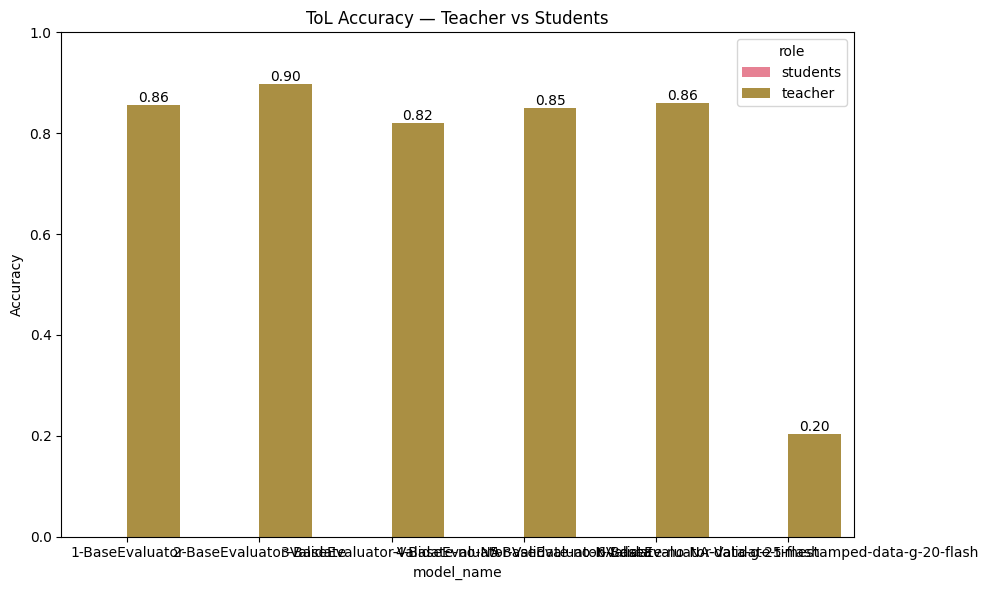

In [ ]:
# 5.1 Accuracy bar-chart: teacher vs students
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=role_acc, x='model_name', y='accuracy', hue='role', ax=ax)
ax.set(title='ToL Accuracy — Teacher vs Students', ylabel='Accuracy', ylim=(0, 1))
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.bar_label(ax.containers[1], fmt='%.2f')
plt.tight_layout()
plt.show()


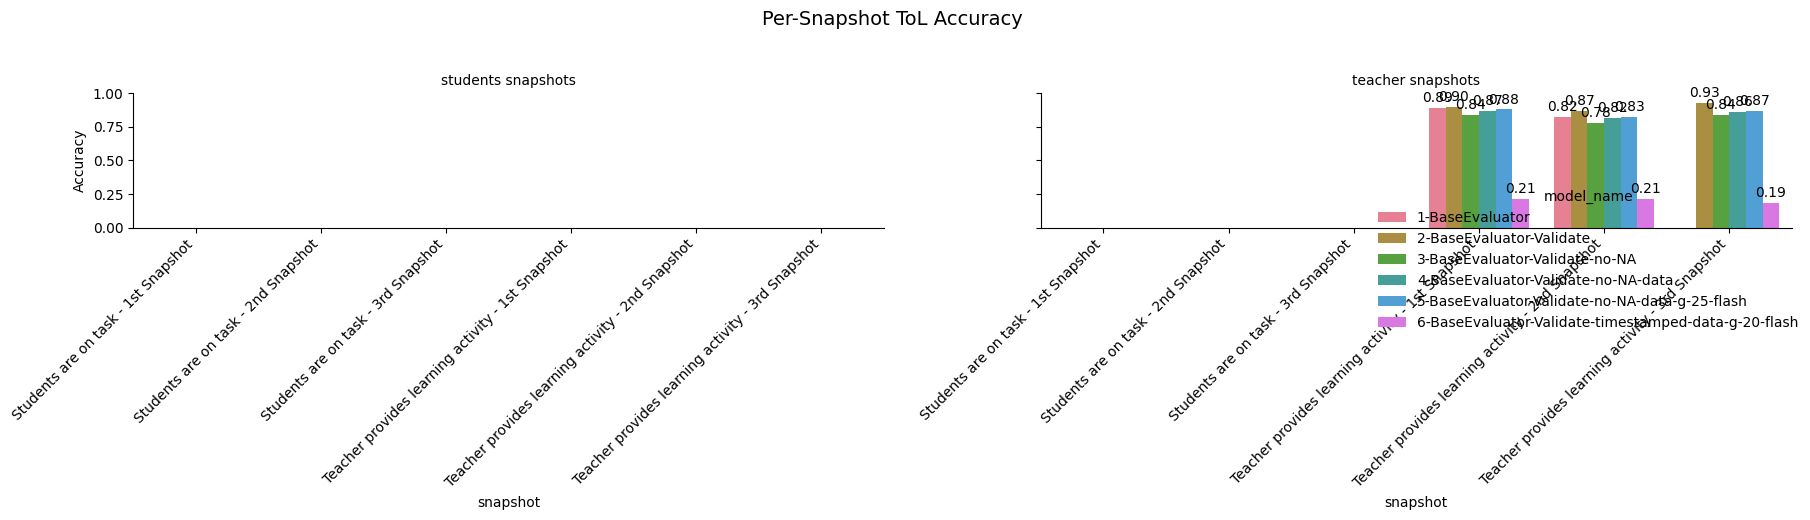

In [ ]:
# 5.2 Per-snapshot accuracy facet
g = sns.catplot(
    data=acc_table,
    x='snapshot', y='accuracy', hue='model_name', col='role',
    kind='bar', height=5, aspect=1.4
)
g.set_titles('{col_name} snapshots')
g.set_xticklabels(rotation=45, ha='right')
g.set(ylabel='Accuracy', ylim=(0, 1))
for ax in g.axes.flat:
    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f', label_type='edge', padding=2)
plt.suptitle('Per-Snapshot ToL Accuracy', y=1.03, fontsize=14)
plt.tight_layout()
plt.show()


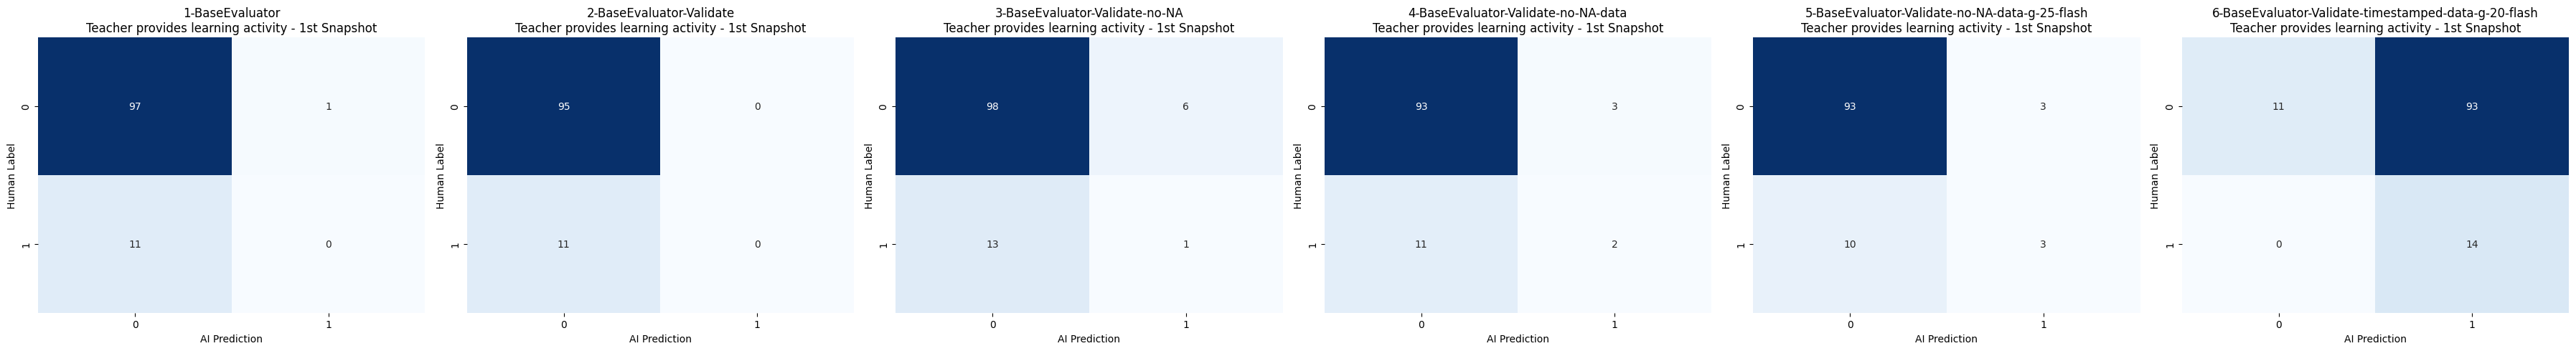

In [ ]:
# 5.3 NaN-safe confusion matrix heat-maps (example: first teacher snapshot)
EXAMPLE_SNAP = 'Teacher provides learning activity - 1st Snapshot'
n_models = len(overall_acc)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
axes = [axes] if n_models == 1 else axes  # handle single-model case

for ax, model in zip(axes, overall_acc['model_name']):
    subset = metrics_df[(metrics_df['model_name'] == model) & (metrics_df['snapshot'] == EXAMPLE_SNAP)]
    # Drop rows with NaN in either column before confusion_matrix
    subset = subset.dropna(subset=['human', 'ai'])
    if subset.empty:
        cm = np.zeros((2, 2), dtype=int)
    else:
        cm = confusion_matrix(subset['human'], subset['ai'], labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set(title=f'{model}\n{EXAMPLE_SNAP}', xlabel='AI Prediction', ylabel='Human Label')

plt.tight_layout()
plt.show()


/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_25559/113158316.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: safe_accuracy(g['human'], g['ai']))


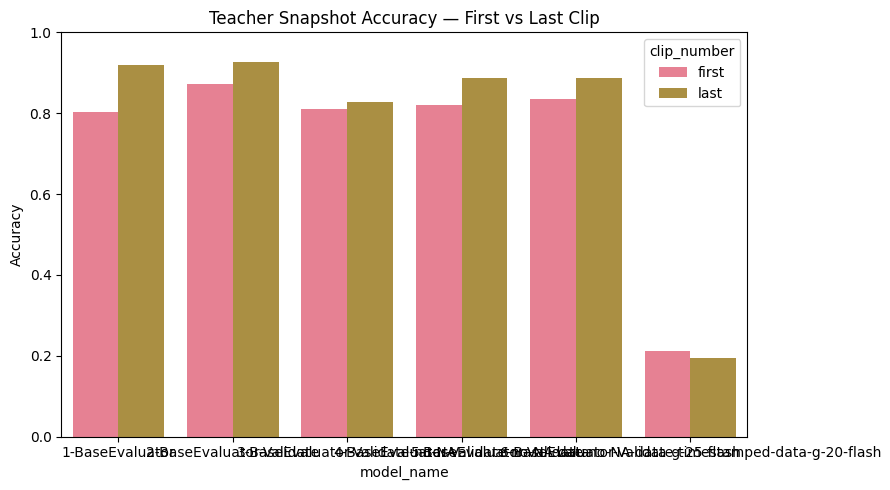

In [ ]:
# 5.4 First vs Last clip accuracy (teacher snapshots only)
teacher_metrics = metrics_df[metrics_df['role'] == 'teacher']
clip_acc = (
    teacher_metrics.groupby(['model_name', 'clip_number'])
    .apply(lambda g: safe_accuracy(g['human'], g['ai']))
    .reset_index(name='accuracy')
)
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=clip_acc, x='model_name', y='accuracy', hue='clip_number', ax=ax)
ax.set(title='Teacher Snapshot Accuracy — First vs Last Clip', ylabel='Accuracy', ylim=(0, 1))
plt.tight_layout()
plt.show()


## 6 · Summary & Interpretation

In [ ]:
overall_acc.sort_values('overall_tol_accuracy', ascending=False)


,model_name,overall_tol_accuracy
1,2-BaseEvaluator-Validate,0.897862
4,5-BaseEvaluator-Validate-no-NA-data-g-25-flash,0.859327
0,1-BaseEvaluator,0.856719
3,4-BaseEvaluator-Validate-no-NA-data,0.850153
2,3-BaseEvaluator-Validate-no-NA,0.819209
5,6-BaseEvaluator-Validate-timestamped-data-g-20...,0.203390


> **Next Steps**  
> * Use the heat-maps to spot systematic mis-labelling (e.g., AI over-predicts “Y” on Snapshot 3).  
> * Drill into specific `(base_id, clip_number)` pairs with largest divergences for qualitative error analysis.
